In [6]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install statsmodels
%pip install datetime

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os as os
from datetime import datetime

In [2]:
percorso_csv = r"../../csv_post_etl"
 
df_appearances = pd.read_csv(percorso_csv + "/appearances_post.csv")
df_club_games = pd.read_csv(percorso_csv + "/club_games_post.csv")
df_clubs = pd.read_csv(percorso_csv + "/clubs_post.csv")
df_competitions = pd.read_csv(percorso_csv + "/competitions_post.csv")
df_game_events = pd.read_csv(percorso_csv + "/game_events_post.csv")
df_game_lineups = pd.read_csv(percorso_csv + "/game_lineups_post.csv")
df_games = pd.read_csv(percorso_csv + "/games_post.csv")
df_player_valuations = pd.read_csv(percorso_csv + "/player_valuations_post.csv")
df_players = pd.read_csv(percorso_csv + "/players_post.csv")

In [3]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

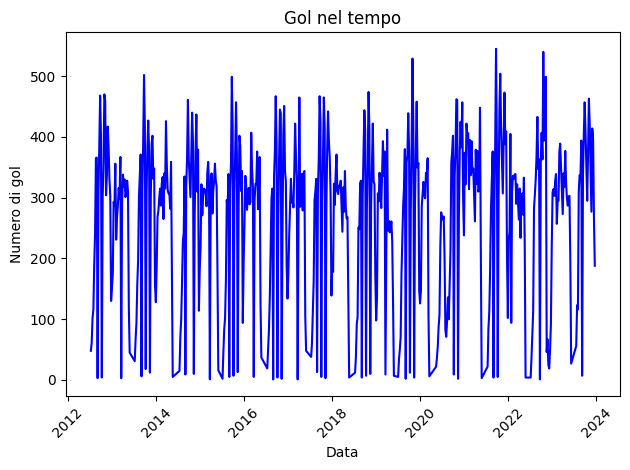

Test Statistic         -7.933885e+00
p-value                 3.454758e-12
Lags                    1.400000e+01
Observations            5.140000e+02
Critical Value (1%)    -3.443136e+00
Critical Value (5%)    -2.867179e+00
Critical Value (10%)   -2.569774e+00
dtype: float64


In [30]:
df_per_previsione_gol = df_game_events[['date', 'game_id']].where(df_game_events["type"] == "Goals").dropna()
#print(df_per_previsione_gol.head())
df_per_previsione_gol['date'] = pd.to_datetime(df_per_previsione_gol['date'])

df_per_previsione_gol['date'] = df_per_previsione_gol['date'].dt.to_period('W').dt.to_timestamp()
#df_per_previsione_gol["date"] = pd.to_datetime(df_per_previsione_gol["date"])

df_per_previsione_gol = df_per_previsione_gol.set_index('date')
#print(df_per_previsione_gol)

df_per_previsione_gol_counts = df_per_previsione_gol
df_per_previsione_gol_counts= df_per_previsione_gol.groupby(['date']).size().reset_index(name='goal')

#sostituisci gli 0 con Nan
df_per_previsione_gol_counts['goal'] = df_per_previsione_gol_counts['goal'].replace(0, np.nan)
 
# Sostituisci NaN con il valore più vicino diverso da zero
df_per_previsione_gol_counts['goal'] = df_per_previsione_gol_counts['goal'].fillna(method='ffill').fillna(method='bfill')

pd.set_option('display.max_row', None)
#print(df_per_previsione_gol_counts)
# Crea il plot mondiale supremo
plt.plot(df_per_previsione_gol_counts['date'], df_per_previsione_gol_counts["goal"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Gol nel tempo')
plt.xlabel('Data')
plt.ylabel('Numero di gol')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.savefig("../../images/serie_temp_gol.png")
plt.show()

differenced_series_gol = df_per_previsione_gol_counts
differenced_series_gol = differenced_series_gol.set_index('date')
test_stationarity(differenced_series_gol["goal"])




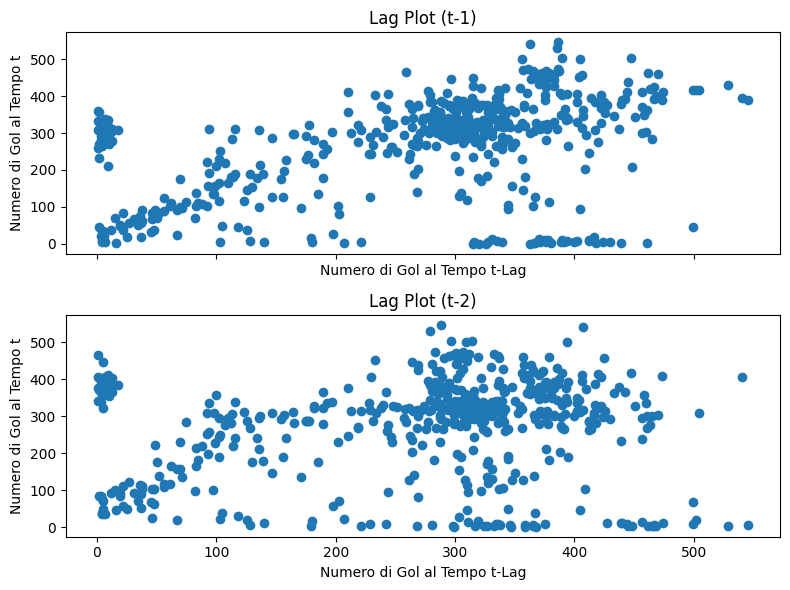

In [5]:
# Aggiungi colonne con i valori ritardati (lag) al dataframe
df_per_previsione_gol_counts['goal_lag'] = df_per_previsione_gol_counts['goal'].shift(1)
df_per_previsione_gol_counts['goal_lag2'] = df_per_previsione_gol_counts['goal'].shift(2)

# Rimuovi le prime righe che avranno valori NaN a causa dello shift
df_per_previsione_gol_counts = df_per_previsione_gol_counts.dropna()

# Crea un subplot con due righe e una colonna
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

# Primo subplot
axes[0].scatter(df_per_previsione_gol_counts['goal_lag'], df_per_previsione_gol_counts['goal'])
axes[0].set_title('Lag Plot (t-1)')

# Secondo subplot
axes[1].scatter(df_per_previsione_gol_counts['goal_lag2'], df_per_previsione_gol_counts['goal'])
axes[1].set_title('Lag Plot (t-2)')

for ax in axes:
    ax.set_xlabel('Numero di Gol al Tempo t-Lag')
    ax.set_ylabel('Numero di Gol al Tempo t')

# Mostra il plot
plt.tight_layout()
plt.savefig("../../images/lag_plot_gol.png")
plt.show()

         date  goal
0  2012-07-09    48
1  2012-07-16    61
2  2012-07-23   102
3  2012-07-30   116
4  2012-08-06   189
5  2012-08-13   242
6  2012-08-20   365
7  2012-08-27   366
8  2012-09-03     3
9  2012-09-10   304
10 2012-09-17   387
11 2012-09-24   468
12 2012-10-01   400
13 2012-10-08     4
14 2012-10-15   301
15 2012-10-22   357
16 2012-10-29   470
17 2012-11-05   460
18 2012-11-12   304
19 2012-11-19   336
20 2012-11-26   417
21 2012-12-03   383
22 2012-12-10   331
23 2012-12-17   303
24 2012-12-24   130
25 2012-12-31   154
26 2013-01-07   175
27 2013-01-14   293
28 2013-01-21   287
29 2013-01-28   356
30 2013-02-04   231
31 2013-02-11   268
32 2013-02-18   287
33 2013-02-25   316
34 2013-03-04   298
35 2013-03-11   367
36 2013-03-18     3
37 2013-03-25   291
38 2013-04-01   338
39 2013-04-08   318
40 2013-04-15   330
41 2013-04-22   301
42 2013-04-29   308
43 2013-05-06   328
44 2013-05-13   310
45 2013-05-20   118
46 2013-05-27    45
47 2013-07-08    31
48 2013-07-15    67


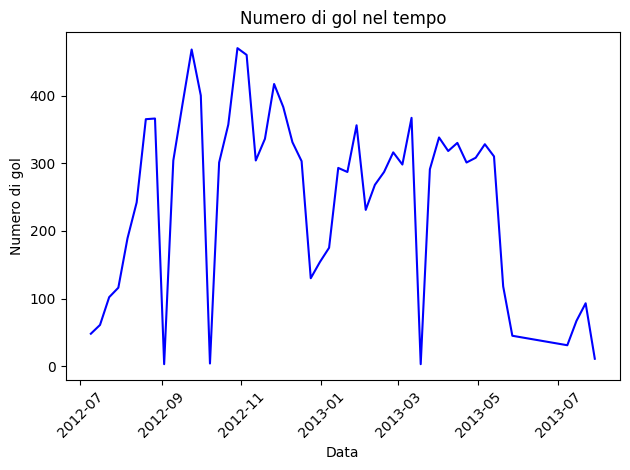

            goal
date            
2012-07-09    48
2012-07-16    61
2012-07-23   102
2012-07-30   116
2012-08-06   189
2012-08-13   242
2012-08-20   365
2012-08-27   366
2012-09-03     3
2012-09-10   304
2012-09-17   387
2012-09-24   468
2012-10-01   400
2012-10-08     4
2012-10-15   301
2012-10-22   357
2012-10-29   470
2012-11-05   460
2012-11-12   304
2012-11-19   336
2012-11-26   417
2012-12-03   383
2012-12-10   331
2012-12-17   303
2012-12-24   130
2012-12-31   154
2013-01-07   175
2013-01-14   293
2013-01-21   287
2013-01-28   356
2013-02-04   231
2013-02-11   268
2013-02-18   287
2013-02-25   316
2013-03-04   298
2013-03-11   367
2013-03-18     3
2013-03-25   291
2013-04-01   338
2013-04-08   318
2013-04-15   330
2013-04-22   301
2013-04-29   308
2013-05-06   328
2013-05-13   310
2013-05-20   118
2013-05-27    45
2013-07-08    31
2013-07-15    67
2013-07-22    93
2013-07-29    11
Test Statistic          -4.046015
p-value                  0.001188
Lags                     0.0000

In [6]:
df_per_previsione_gol_prova = df_game_events['date'].where(df_game_events["type"] == "Goals").dropna()
df_per_previsione_gol_prova = pd.DataFrame(df_per_previsione_gol_prova)
#print(df_per_previsione_gol.head())
df_per_previsione_gol_prova['date'] = pd.to_datetime(df_per_previsione_gol_prova['date'])
df_per_previsione_gol_prova = df_per_previsione_gol_prova[df_per_previsione_gol_prova['date'] <= '2013-07-30']
df_per_previsione_gol_prova['date'] = df_per_previsione_gol_prova['date'].dt.to_period('W').dt.to_timestamp()
df_per_previsione_gol_prova["date"] = pd.to_datetime(df_per_previsione_gol_prova["date"])


df_per_previsione_gol_prova = df_per_previsione_gol_prova.set_index('date')
#print(df_per_previsione_gol)
 
df_per_previsione_gol_counts_prova = df_per_previsione_gol_prova
df_per_previsione_gol_counts_prova = df_per_previsione_gol_prova.groupby(['date']).size().reset_index(name='goal')
print(df_per_previsione_gol_counts_prova)
# Crea il plot mondiale supremo
plt.plot(df_per_previsione_gol_counts_prova['date'], df_per_previsione_gol_counts_prova["goal"], linestyle='-', color='b')
 
# Personalizza il plot
plt.title(f'Numero di gol nel tempo')
plt.xlabel('Data')
plt.ylabel('Numero di gol')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità
 
# Mostra il plot
plt.tight_layout()
plt.savefig("../../images/stagionalita_ristretta.png")
plt.show()
 
differenced_series_gol_prova = df_per_previsione_gol_counts_prova
differenced_series_gol_prova = differenced_series_gol_prova.set_index('date')
print(differenced_series_gol_prova)

#adf_provo = adfuller(differenced_series_gol.dropna())
#print("ADF Statistics: %f" %adf_provo[0])
#print("p-value: %f" %adf_provo[1])
test_stationarity(differenced_series_gol_prova["goal"])

date
2012-07-09     48
2012-07-16     61
2012-07-23    102
2012-07-30    116
2012-08-06    189
2012-08-13    242
2012-08-20    365
2012-08-27    366
2012-09-03      3
2012-09-10    304
2012-09-17    387
2012-09-24    468
2012-10-01    400
2012-10-08      4
2012-10-15    301
2012-10-22    357
2012-10-29    470
2012-11-05    460
2012-11-12    304
2012-11-19    336
2012-11-26    417
2012-12-03    383
2012-12-10    331
2012-12-17    303
2012-12-24    130
2012-12-31    154
2013-01-07    175
2013-01-14    293
2013-01-21    287
2013-01-28    356
2013-02-04    231
2013-02-11    268
2013-02-18    287
2013-02-25    316
2013-03-04    298
2013-03-11    367
2013-03-18      3
2013-03-25    291
2013-04-01    338
2013-04-08    318
2013-04-15    330
2013-04-22    301
2013-04-29    308
2013-05-06    328
2013-05-13    310
2013-05-20    118
2013-05-27     45
2013-07-08     31
2013-07-15     67
2013-07-22     93
2013-07-29     11
Name: goal, dtype: int64


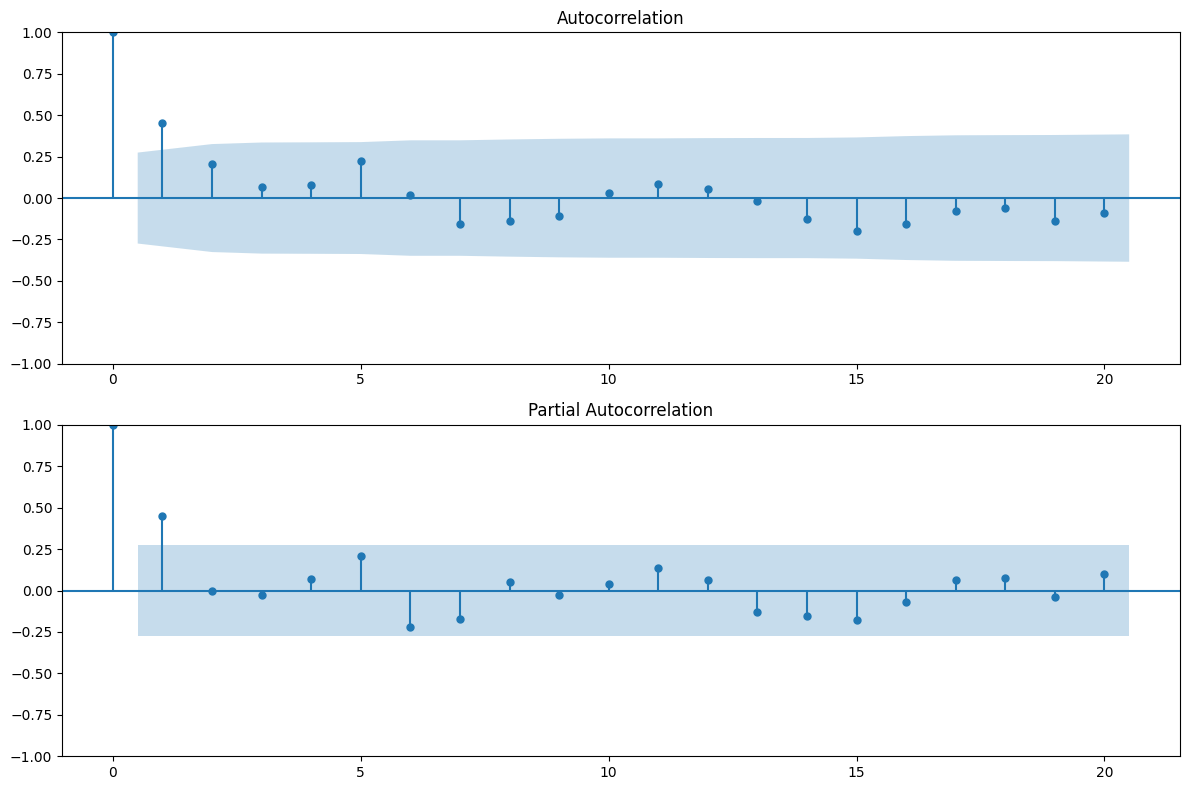

In [7]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
print(differenced_series_gol_prova["goal"])
fig = sm.graphics.tsa.plot_acf(differenced_series_gol_prova["goal"][0:], lags=20, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series_gol_prova["goal"][0:], lags=20, ax=ax2)
plt.tight_layout()
plt.savefig("../../images/ac_pac_stagionalita_ristretta.png")

In [8]:
print(differenced_series_gol)

            goal
date            
2012-07-09    48
2012-07-16    61
2012-07-23   102
2012-07-30   116
2012-08-06   189
2012-08-13   242
2012-08-20   365
2012-08-27   366
2012-09-03     3
2012-09-10   304
2012-09-17   387
2012-09-24   468
2012-10-01   400
2012-10-08     4
2012-10-15   301
2012-10-22   357
2012-10-29   470
2012-11-05   460
2012-11-12   304
2012-11-19   336
2012-11-26   417
2012-12-03   383
2012-12-10   331
2012-12-17   303
2012-12-24   130
2012-12-31   154
2013-01-07   175
2013-01-14   293
2013-01-21   287
2013-01-28   356
2013-02-04   231
2013-02-11   268
2013-02-18   287
2013-02-25   316
2013-03-04   298
2013-03-11   367
2013-03-18     3
2013-03-25   291
2013-04-01   338
2013-04-08   318
2013-04-15   330
2013-04-22   301
2013-04-29   308
2013-05-06   328
2013-05-13   310
2013-05-20   118
2013-05-27    45
2013-07-08    31
2013-07-15    67
2013-07-22    93
2013-07-29   157
2013-08-05   197
2013-08-12   302
2013-08-19   338
2013-08-26   371
2013-09-02     6
2013-09-09   3

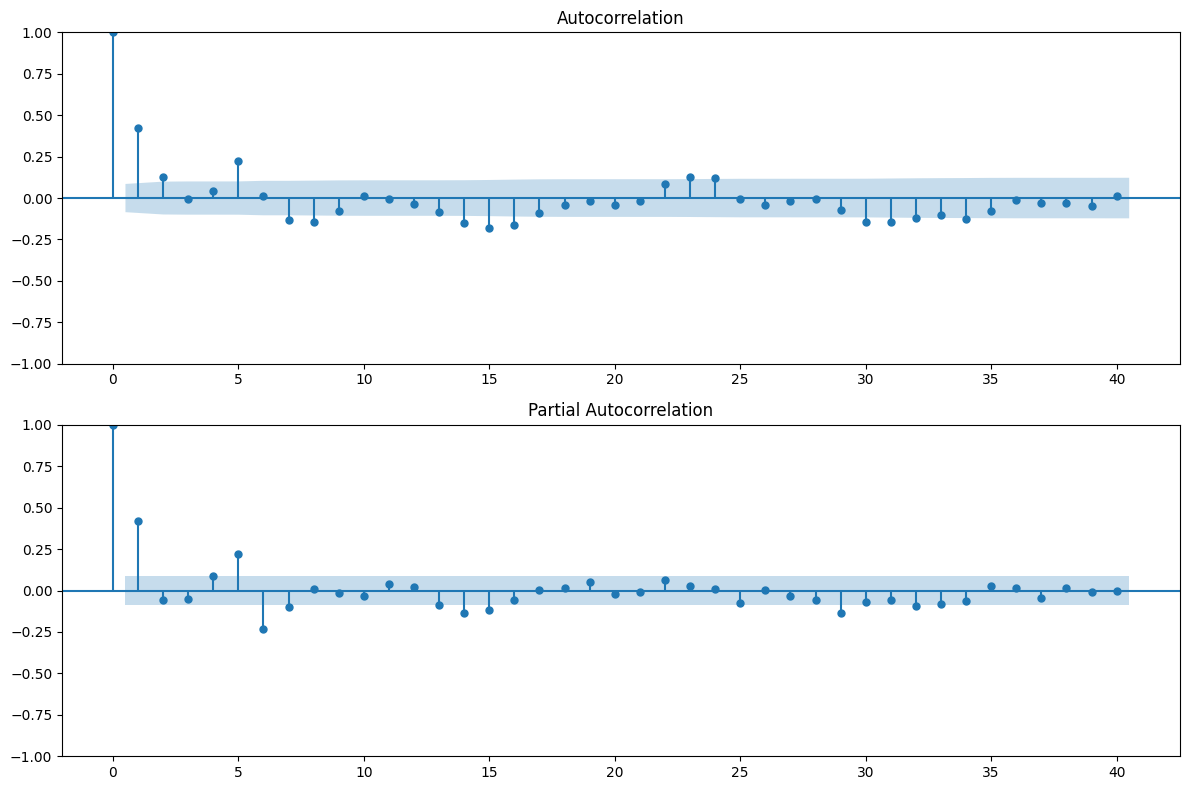

In [9]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(differenced_series_gol["goal"][0:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series_gol["goal"][0:], lags=40, ax=ax2)
plt.tight_layout()
plt.savefig("../../images/ac_pac_serie_temp_gol.png")

In [10]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   goal   No. Observations:                  529
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3360.799
Date:                Wed, 17 Jan 2024   AIC                           6725.598
Time:                        17:30:03   BIC                           6734.140
Sample:                             0   HQIC                          6728.941
                                - 529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8847      0.026     34.100      0.000       0.834       0.936
sigma2      1.925e+04   1263.664     15.236      0.000    1.68e+04    2.17e+04
Ljung-Box (L1) (Q):                  30.94   Jarque-

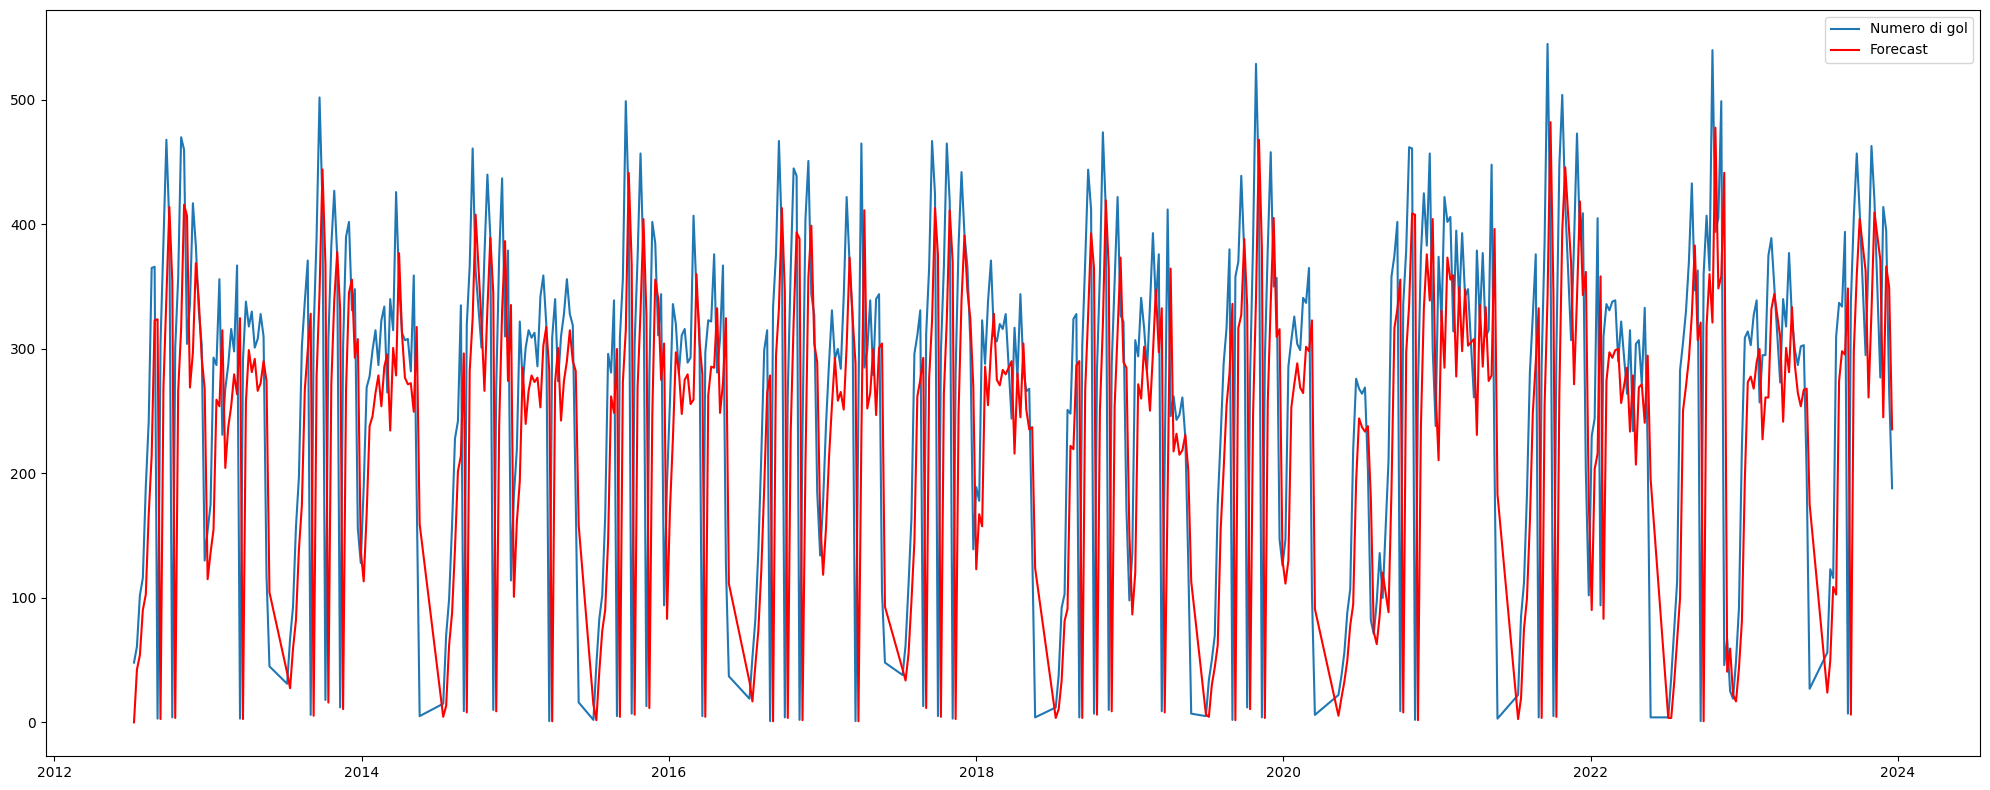

In [37]:

from pmdarima.arima import auto_arima

#prova a modificare i parametri
# fit SARIMAX model
fig = plt.figure(figsize=(20,8))

model_a = auto_arima(differenced_series_gol["goal"], start_p=1, start_q=1, test = 'adf', max_p=2, max_q=2, m=52, d=0, seasonal=True, start_P=0, start_Q=0, max_P=2, max_Q=2, D=None, trace=True)
model_a.summary()

model = SARIMAX(differenced_series_gol["goal"], order=(1,0,0), seasonal_order=(1,0,1,52)) #order(p,d,q) per p guardo PARZIAL-AC per q guardo AC qui order avevi (1,0,2)
ax = plt.gca()
results = model.fit() 
plt.plot(differenced_series_gol["goal"])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Numero di gol', 'Forecast'])
plt.tight_layout()
plt.savefig("../../images/model_SARIMAX_serie_temp.png")

print(results.summary())


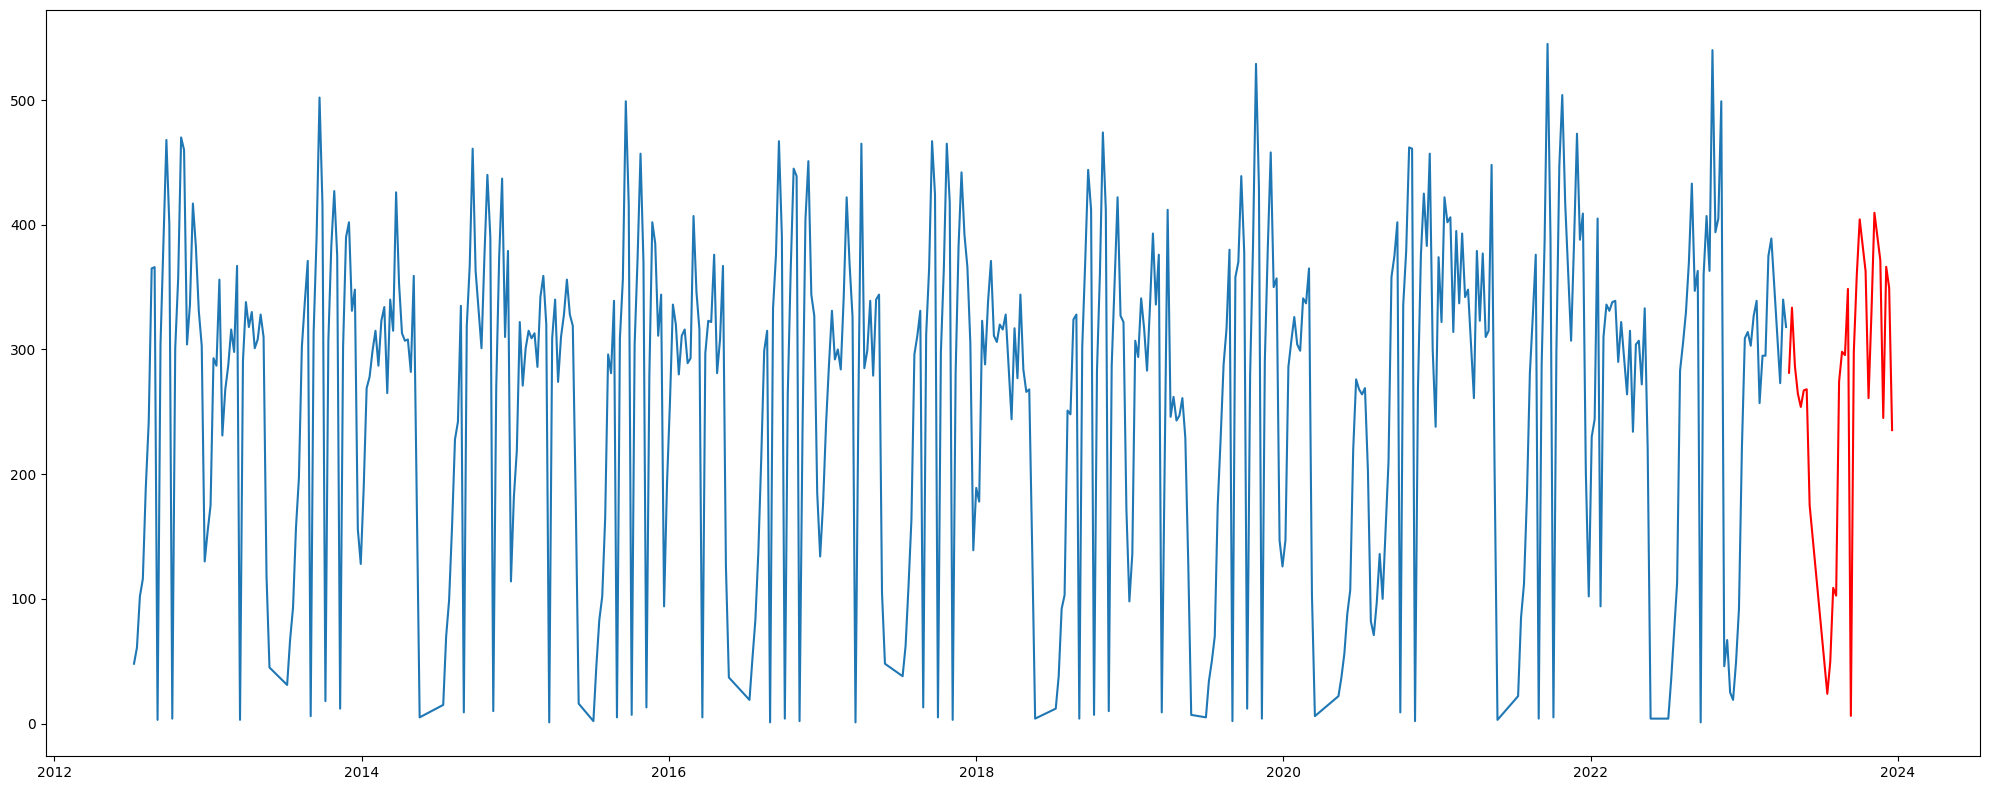

In [38]:
fig = plt.figure(figsize=(20,8))
num_points = len(differenced_series_gol['goal'])
x = results.predict(start=(500), end=(528), dynamic=False)
plt.plot(differenced_series_gol['goal'][:500])
plt.plot(x, color='r')
plt.tight_layout()
plt.savefig("../../images/prediction_SARIMAX_serie_temp_gol.png")

c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


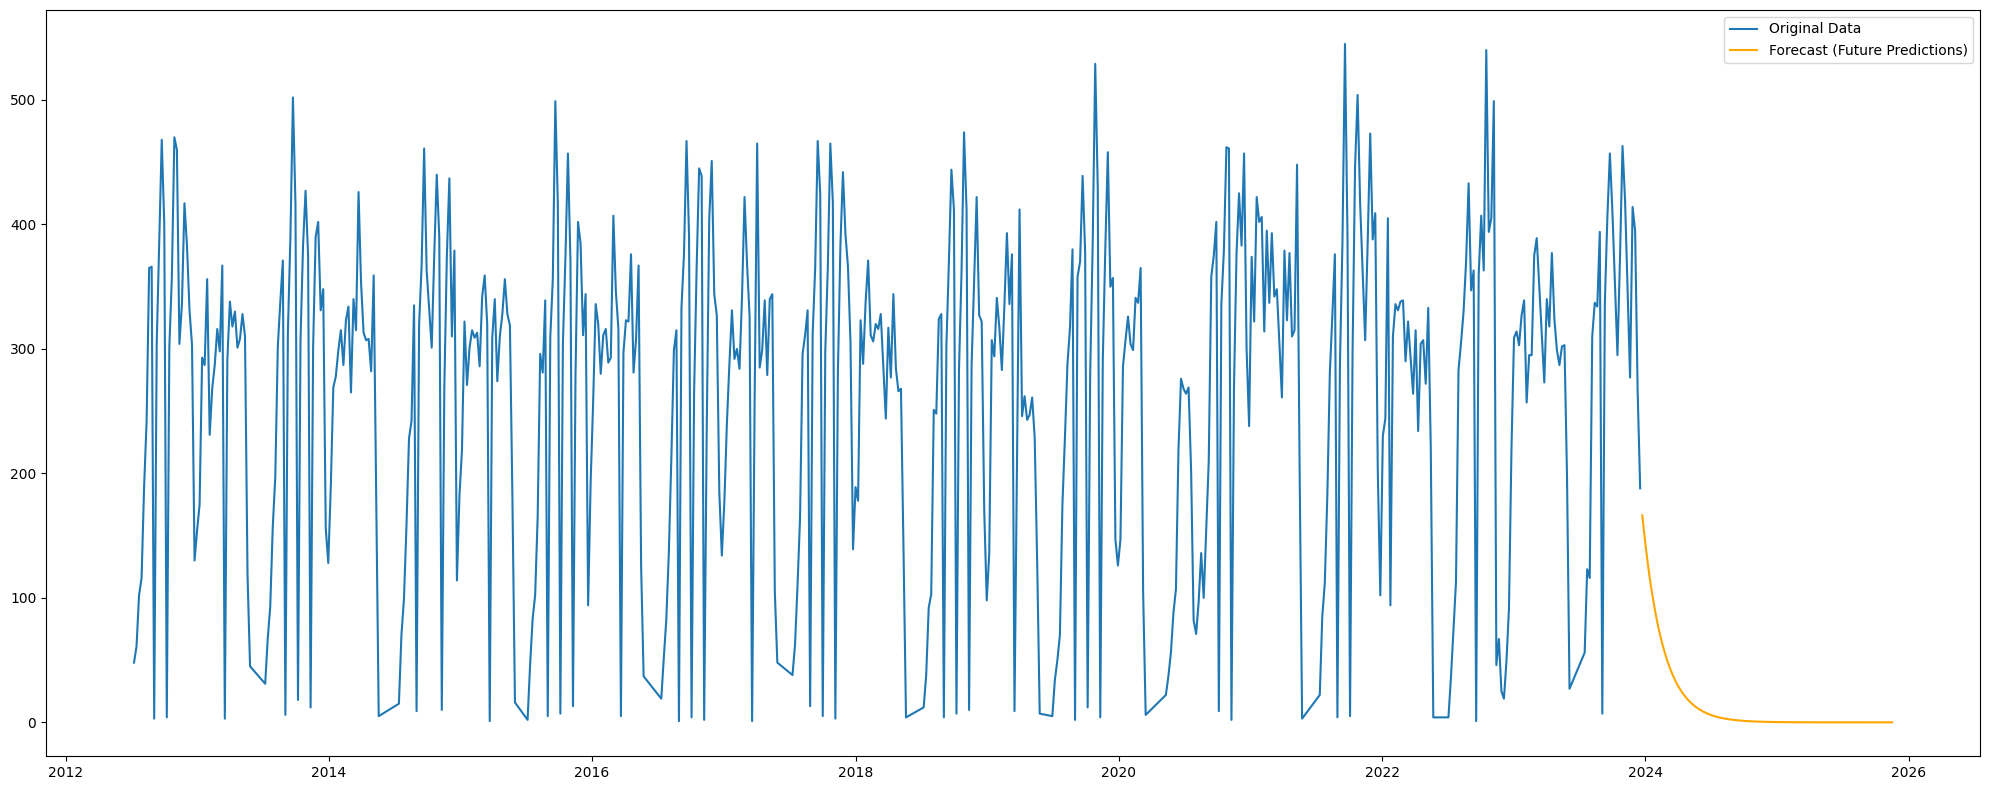

In [39]:
import matplotlib.pyplot as plt

# ... (Assicurati di aver già definito results2 e che i dati siano pronti)

# Calcola le predizioni per periodi futuri (out-of-sample)
future_steps = 100  # Modifica il numero di passi in base alle tue esigenze
forecast_results = results.get_forecast(steps=future_steps)
forecast_results2 = results.get_forecast(steps=future_steps).summary_frame()
print(forecast_results)

# Estrai le predizioni per periodi futuri
forecast_values = forecast_results.predicted_mean
# Imposta manualmente la frequenza temporale
manual_freq = 'W'  # Modifica in base alla tua frequenza desiderata (es. 'D' per giorni)

# Calcola il passo temporale per la frequenza delle tue date
last_date = differenced_series_gol.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq=manual_freq)
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))

# Original data (assuming your original data is in a variable named 'your_original_data')
ax.plot(differenced_series_gol.index, differenced_series_gol['goal'], label='Original Data')

# Out-of-sample predictions
ax.plot(forecast_index, forecast_values, color='orange', label='Forecast (Future Predictions)')

ax.legend()
plt.tight_layout()
plt.savefig("../../images/forecasat_serie_temp_gol.png")
plt.show()
